In [267]:
import numpy as np
import sklearn.linear_model as lm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # a visualization lib based on matplotlib, more convenient and beautiful

In [268]:
df = pd.read_csv('dataport-export_gas_oct2015-mar2016.csv')
print(df.head())
print(f'The indices are: {df.columns}')

              localminute  dataid  meter_value
0  2015-10-01 00:00:10-05     739        88858
1  2015-10-01 00:00:13-05    8890       197164
2  2015-10-01 00:00:20-05    6910       179118
3  2015-10-01 00:00:22-05    3635       151318
4  2015-10-01 00:00:22-05    1507       390354
The indices are: Index(['localminute', 'dataid', 'meter_value'], dtype='object')


1.1 How many houses are included in the measurement study? Are there any malfunctioning meters? If so, identify them and the time periods where they were malfunctioning. The information below regarding data collection may be useful.

157 houses

Many types of malfunctioning meters: 

1. Since the homes in this neighborhood are primarily newly constructed (including single-family homes, apartments, and town homes), the meters first occur after 2015-10-01 with large meter values may malfunction or just the case that the are newly move in this house.

2. the meter reading decreases since time goes by.

3. the meter reading increase a lot in a short time period.

4. the meter doesn't report to the meter data management center (MDMC).




1.1.1 the first case

get the first record of each home and a list of dataid for further analysis.

last 37 meters in df_start may be malfunctional.



In [269]:
df_start = df.drop_duplicates(subset='dataid',keep='first',inplace=False)
df_end = df.drop_duplicates(subset='dataid',keep='last',inplace=False)
# get a list of meterID
homeid = list(df_start['dataid'])
print("Total number of meters is :", len(df_start))
if not df.isnull().values.any():
    print("There is no data missing or 'NaN'")
print("Check the report time for the last 40 meters:" )
df_start.tail(40)

Total number of meters is : 157
There is no data missing or 'NaN'
Check the report time for the last 40 meters:


,localminute,dataid,meter_value
4478,2015-10-01 12:47:44-05,2378,159376
4931,2015-10-01 14:10:29-05,6830,150386
6966,2015-10-01 20:04:43-05,9766,158512
11436,2015-10-02 08:54:27-05,4193,289668
18211,2015-10-03 03:48:54-05,8703,210416
18597,2015-10-03 04:51:53-05,6578,157806
35710,2015-10-05 02:44:01-05,4228,85162
47472,2015-10-06 11:52:20-05,2645,59318
63854,2015-10-08 10:01:28-05,6505,132928
63993,2015-10-08 10:22:34-05,5395,136658


In [270]:

dec_change = pd.DataFrame(columns=['localminute','dataid','meter_value'])
inc_huge = pd.DataFrame(columns=['localminute','dataid','meter_value'])

for i in homeid:
    # print(i)
    df_home = df[df['dataid']==i]
    readings = list(df_home['meter_value'])
    
    for j in range(len(df_home)-1):
        if (readings[j+1] - readings[j]) < 0:
            dec_change = dec_change.append(df_home.iloc[j:j+2])
        if (readings[j+1] - readings[j]) >= 200:
            inc_huge = inc_huge.append(df_home.iloc[j:j+2])


1.1.2. the meter reading decreases since time goes by.

check each meter and return the meter_id and time stamp

In [271]:
dec_start = dec_change.drop_duplicates(subset='dataid',keep='first',inplace=False)
# dec_id = list(dec_start['dataid'])
print(f"\nIn total, {len(dec_start)} meters have decreasing values.")
print("\nHere are the meters that occurs decreasing value and the corresponding times.")
dec_times = dec_change.pivot_table(index=['dataid'],aggfunc='size')
print('\n',(dec_times/2).astype('int'))


In total, 43 meters have decreasing values.

Here are the meters that occurs decreasing value and the corresponding times.

 dataid
35        1
77        1
94        6
483       1
484       9
1042      1
1086      1
1185    135
1507      2
1556     12
1718      4
1790      1
1801      1
2129      3
2335      5
2449     93
3134     18
3527      1
3544     18
3893      2
4031     16
4193      1
4514    141
4998      1
5129     76
5131      1
5193      4
5403    156
5810     10
5814      1
5892      1
6836     51
7017      1
7030     90
7117    123
7739      1
7794      1
7989      2
8156    151
8890     44
9134    115
9639      2
9982      2
dtype: int32


In [272]:
#We consider data increasing more than 10 times will be dropped
drop_indices = list(dec_times.where(dec_times < 22).dropna().index)
df = df.set_index(df.dataid)
df.drop(drop_indices, inplace = True)

Consider more than 20 times is malfunction. Take a look at 10 samples of "1185"

In [273]:
df[df.dataid == 35]

,localminute,dataid,meter_value
dataid,,,


In [274]:
dec_exa = dec_change[dec_change['dataid']==1185]
dec_exa.head(20)

,localminute,dataid,meter_value
143717,2015-10-17 10:50:54-05,1185,139798
143720,2015-10-17 10:51:09-05,1185,139796
143782,2015-10-17 10:59:49-05,1185,139798
143836,2015-10-17 11:08:06-05,1185,139796
144068,2015-10-17 11:43:41-05,1185,139800
144087,2015-10-17 11:47:03-05,1185,139798
144386,2015-10-17 12:31:41-05,1185,139806
144399,2015-10-17 12:33:57-05,1185,139802
144586,2015-10-17 13:03:51-05,1185,139812
144745,2015-10-17 13:27:01-05,1185,139806


1.1.3. the meter reading increase a lot in a short time period.

Take larger that 200 cubics increase between two adjacent records as an outlier.


In [275]:
inc_start = inc_huge.drop_duplicates(subset='dataid',keep='first',inplace=False)
print(f"\n There are {len(inc_start)} meters has outlier.")
print("\n Take a brief look at 10 outliers of some meters.")
inc_huge.head(20)


 There are 93 meters has outlier.

 Take a brief look at 10 outliers of some meters.


,localminute,dataid,meter_value
609165,2015-12-07 23:41:42-06,3635,155548
618896,2015-12-09 00:26:36-06,3635,155788
732234,2015-12-21 00:29:14.700727-06,4352,223624
1132977,2016-02-04 13:18:31.172764-06,4352,233896
1154982,2016-02-06 22:15:47.473284-06,4352,234414
1159974,2016-02-07 11:23:17.30182-06,4352,234672
1422869,2016-03-08 18:09:51.535581-06,4352,236952
1464967,2016-03-14 18:47:32.658793-05,4352,237172
1491179,2016-03-18 11:27:23.980261-05,4352,237230
1515940,2016-03-21 21:41:15.66264-05,4352,237674


Apparently, there are two kinds of outliers.

One is report period is much longer, but the value make sense.

The other one just alternate between two values, such as "8156". These kind of meter will be considered as malfunction.


In [276]:
outliers = pd.DataFrame(columns=['localminute','dataid','meter_value'])
for i in homeid:
    # print(i)
    df_home = df[df['dataid']==i]
    readings = list(df_home['meter_value'])

    for j in range(len(df_home)-1):
        if (readings[j+1] - readings[j]) >= 2000:
            outliers = outliers.append(df_home.iloc[j:j+2])

In [277]:
out_start = outliers.drop_duplicates(subset='dataid',keep='first',inplace=False)
out_times = outliers.pivot_table(index=['dataid'],aggfunc='size')
print('\n Here are the meters that occurs outliers and the corresponding times.')
print('\n', (out_times/2).astype(int))



 Here are the meters that occurs outliers and the corresponding times.

 dataid
222       5
1185    125
1556     10
2233      2
2449     91
2638      1
2645      1
3039      1
3134     17
3544     18
4352      1
4421      1
4447      1
4514    126
4671      1
4874      1
5129     73
5403    136
5545      2
6505      1
6685      3
6836     50
6863      2
7030     79
7117    111
7460      1
7919      1
7965      1
8156    139
8467      1
8703      2
9134    111
9474      1
9620      4
9956      1
dtype: int32


After a brief look, half of the outliers should be dropped for meter ID:

1185, 1556, 2449, 3134, 3544, 4514, 5129, 5403, 6836, 7030, 7117, 8156, 9134

In [278]:
#out_times more than 10 will be dropped
drop_indices = list(out_times.where(out_times < 22).dropna().index)
df.drop(drop_indices, inplace = True)

1.1.4 the meter doesn't report to the meter data management center (MDMC).

In [279]:
from datetime import datetime
stop_report = pd.DataFrame(columns=['localminute','dataid','meter_value'])
stop_ids = []
m,n = 0,0
for i in homeid:
    df_home = df[df['dataid']==i]
    time_list = list(df_home['localminute'])
    readings = list(df_home['meter_value'])

    for j in range(len(df_home)-1):
        time_1 = datetime.strptime(time_list[j][:19], "%Y-%m-%d %H:%M:%S")
        time_2 = datetime.strptime(time_list[j+1][:19], "%Y-%m-%d %H:%M:%S")

        if ((time_2-time_1).seconds>=60*60*24 or (time_2-time_1).days>=1)\
            and readings[j+1]-readings[j]>7200:
            # save 3 examples for 3 meters
            # if n<3:
            if m<10:
                stop_report = stop_report.append(df_home.iloc[j:j+2])
                m+=1
                # n+=1
            stop_ids.append(i)

stop_ids = list(set(stop_ids))
print(f"\nThere are {len(stop_ids)} meters upload readings in a time period longer than 1 hour with more than 20 cubics gas consumed.")
#print("\nChoose 10 instances as examples.")
stop_report


There are 0 meters upload readings in a time period longer than 1 hour with more than 20 cubics gas consumed.


,localminute,dataid,meter_value


1.2 Generate hourly readings from the raw data. Select one month from the 6-month
study interval and plot the hourly readings (time-series) for that month. Hint:
You will have to decide what to do if there are no readings for a certain hour.

In [280]:
year = []
month = []
day = []
hour = []
minute = []
sec = []
absolute_sec = []
df.columns = ['date', 'id', 'measurement']
df.reset_index(inplace = True)


for i,j in df.iterrows():
    str_object = j.date
    year.append(int(str_object[:4]))
    month.append(int(str_object[5:7]))
    day.append(int(str_object[8:10]))
    hour.append(int(str_object[11:13]))
    minute.append(int(str_object[14:16]))
    sec.append(int(str_object[17:19]))
    
    abs_sec = sec[i] + 60*minute[i] + 60*60*hour[i] + 24*60*60*(day[i] - 1)  
    if (month[i] == 10):   
        abs_sec += 0
    elif (month[i] == 11):
        abs_sec += 31*24*60*60
    elif (month[i] == 12):
        abs_sec += (30+31)*24*60*60
    elif (month[i] == 1):
        abs_sec += (31+30+31)*24*60*60
    elif (month[i] == 2):
        abs_sec += (31+31+30+31)*24*60*60
    elif (month[i] == 3):
        abs_sec += (29+31+31+30+31)*24*60*60
    absolute_sec.append(abs_sec) 
    

df.insert(1, 'year', year, allow_duplicates = True)
df.insert(2, 'month', month, allow_duplicates = True)
df.insert(3, 'day', day, allow_duplicates = True)
df.insert(4, 'hour', hour, allow_duplicates = True)
df.insert(5, 'minute', minute, allow_duplicates = True)
df.insert(6, 'sec', sec, allow_duplicates = True)
df.insert(7, 'absolute_sec', absolute_sec, allow_duplicates = True)


In [213]:
def getID (df, id):
    df_id = pd.DataFrame({'date': [], 
                          'year': [],
                            'month': [],
                             'day': [],
                            'hour': [],
                            'minute': [],
                            'sec': [],
                          'absolute_sec': [],
                         'id': [],
                         'measurement': []})
    
    for i,j in df.iterrows():                 #change 100 back to len(df)
        if j.dataid == id:
            df_id = df_id.append(df.iloc[i, :])
            
    return df_id

In [214]:
def getMonth (df, month):
    df_month = pd.DataFrame({'date': [], 
                          'year': [],
                            'month': [],
                             'day': [],
                            'hour': [],
                            'minute': [],
                            'sec': [],
                             'absolute_sec': [],
                         'id': [],
                         'measurement': []})
    
    for i in range (30*24):                    #change 100 back to len(df)
        if df.at[i, 'month'] == month:
            df_month = df_month.append(df.iloc[i, :])
            
    return df_month

In [215]:
def getIDandMonth (df, id, month):
    df_id_month = pd.DataFrame({'date': [], 
                          'year': [],
                            'month': [],
                             'day': [],
                            'hour': [],
                            'minute': [],
                            'sec': [],
                          'absolute_sec': [],
                         'id': [],
                         'measurement': []})
    
    for i in range (len(df)):                 #change 100 back to len(df)
        if df.at[i, 'id'] == id and df.at[i, 'month'] == month:
            df_id_month = df_id_month.append(df.iloc[i, :])
            
    return df_id_month

In [216]:
df_october = getMonth(df, 10)
df_november = getMonth(df, 11)
df_december = getMonth(df, 12)
df_january = getMonth(df, 1)
df_febuary = getMonth(df, 2)
df_march = getMonth(df, 3)

In [217]:
from scipy import interpolate

def hourlyReadings_IDandMonth(df, id, month):
    df_correct = getIDandMonth(df, id, month)
    
    x = df_correct.absolute_sec
    y = df_correct.measurement
    
    tck = interpolate.splrep(x, y)
    
    hourly_readings = []
    if month == 10 or month == 12 or moth == 1 or month == 3:
        for i in range (31*24):
            hourly_readings.append(interpolate.splev(i*60^2, tck))
    elif month == 11:
        for i in range (30*24):
            hourly_readings.append(interpolate.splev(i*60^2, tck))
    elif month == 2:
        for i in range (29*24):
            hourly_readings.append(interpolate.splev(i*60^2, tck))
        
    return hourly_readings

In [218]:
from scipy import interpolate

def hourlyReadings_IDandMonth(df, id, month):
    df_correct = getIDandMonth(df, id, month)
    
    x = df_correct.absolute_sec
    y = df_correct.measurement
    
    tck = interpolate.splrep(x, y)
    
    hourly_readings = []
    if month == 10 or month == 12 or moth == 1 or month == 3:
        for i in range (31*24):
            hourly_readings.append(interpolate.splev(i*60^2, tck))
    elif month == 11:
        for i in range (30*24):
            hourly_readings.append(interpolate.splev(i*60^2, tck))
    elif month == 2:
        for i in range (29*24):
            hourly_readings.append(interpolate.splev(i*60^2, tck))
        
    return hourly_readings

In [219]:
def hourlyReadings_Month(df, month):
    hourly_readings_month = {}

    for x in set(df.id):           #manche ids produzieren wohl Fehler "m > k must hold"
        hourly_readings_bm[x] = hourlyReadings(df, x, bm)
        
    return hourly_readings_month

#hourlyReadings(df, 8890, 10)   warum nan nan?

In [220]:
def plottingOneID(df, id, month):
    if month == 10 or month == 12 or month == 1 or month == 3:
        x = range(0, 31*24)
    elif month == 11:
        x = range(0, 30*24)
    elif month == 2:
        x = range(0, 29*24)

    y = hourlyReadings_IDandMonth(df, id, month)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.plot(x, y, '--k')
    ax.set_xlim(0, 31*24)
    #ax.set_ylim(-100, 100)
    ax.set_title('Hourly reading of Household {} for month {}'.format(id, month))
    plt.xlabel("Hour")
    plt.ylabel("Measurement")
    plt.grid()
    

In [221]:
def plottingThreeID(df, ids, month):
    if month == 10 or month == 12 or month == 1 or month == 3:
        x = range(0, 31*24)
    elif month == 11:
        x = range(0, 30*24)
    elif month == 2:
        x = range(0, 29*24)

    y1 = hourlyReadings_IDandMonth(df, ids[0], month)  #optimiere laufzeit mit _Month
    y2 = hourlyReadings_IDandMonth(df, ids[1], month)
    y3 = hourlyReadings_IDandMonth(df, ids[2], month)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.plot(x, y1, '--k', x, y2, '-', x, y3, '-.')
    ax.set_xlim(0, 31*24)
    #ax.set_ylim(-100, 100)
    ax.set_title('Hourly reading for month {}'.format(month))
    plt.xlabel("Hour")
    plt.ylabel("Measurement")
    plt.grid()
    plt.show()
    

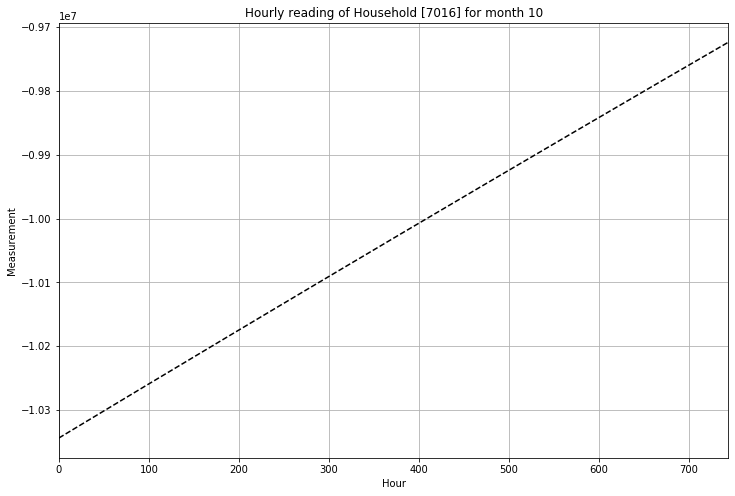

In [222]:
import random

bm = 10 #change to findBestMonth

plottingOneID(df, random.sample(set(df.id),  1), bm)

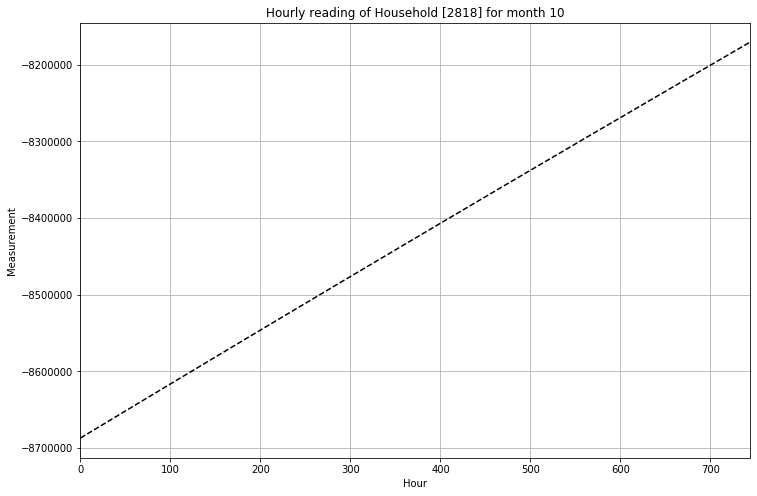

In [223]:
plottingOneID(df, random.sample(set(df.id),  1), bm)

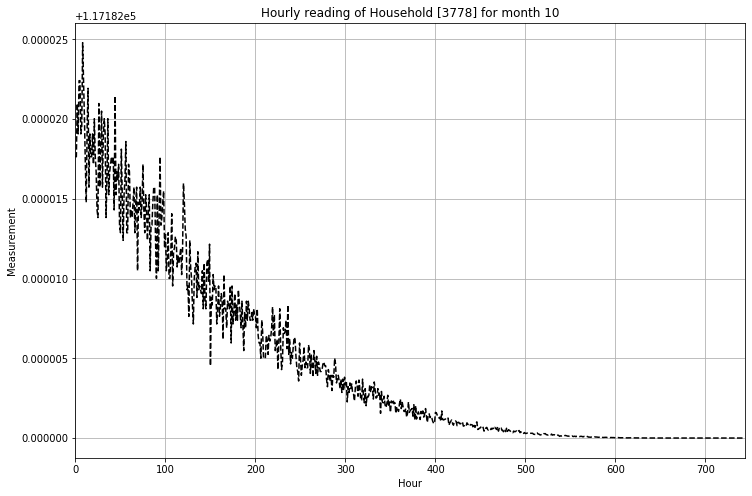

In [224]:
plottingOneID(df, random.sample(set(df.id),  1), bm)

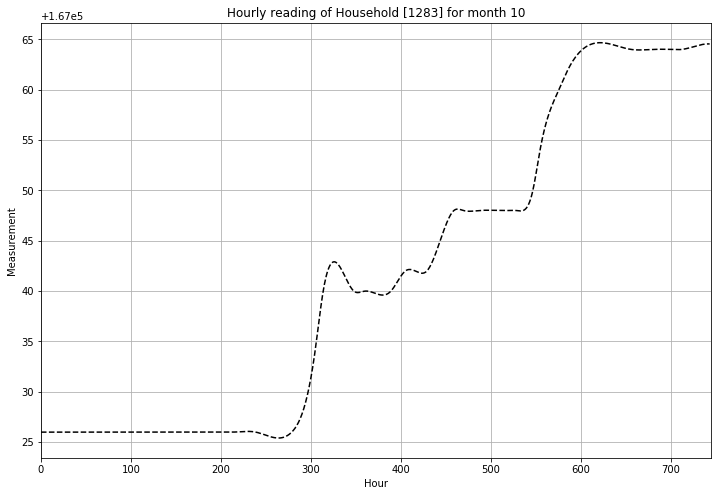

In [225]:
plottingOneID(df, random.sample(set(df.id),  1), bm)

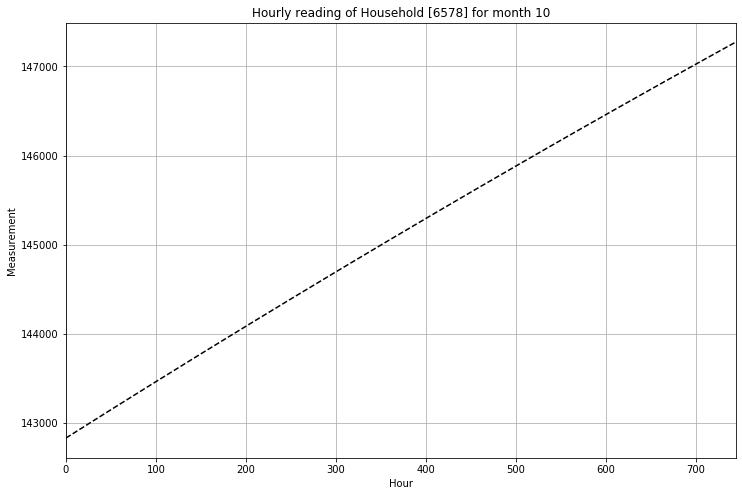

In [226]:
plottingOneID(df, random.sample(set(df.id),  1), bm)

1.3 Intuitively, we expect that gas consumption from different homes to be correlated. For example, many homes would experience higher consumption levels in
the evening when meals are cooked. For each home, fnd the top five homes with
which it shows the highest correlation.

In [289]:
import datetime as dt
#df['date'] = pd.to_datetime(df['date'],  format="%Y/%m/%d %H:%M:%S") 
df['date'] = df['date'].apply(lambda x: 
                                    dt.datetime.strptime(x[:19],'%Y-%m-%d %H:%M:%S'))
df.set_index('date')
df.dtypes

dataid                   int64
year                     int64
month                    int64
day                      int64
hour                     int64
minute                   int64
sec                      int64
absolute_sec             int64
date            datetime64[ns]
id                       int64
measurement              int64
dtype: object

In [338]:
from collections import defaultdict
import sys
series = defaultdict(int)
length = len(list(df.drop_duplicates(subset='dataid',keep='first',inplace=False)['dataid']))
i = 1
for dataid in list(df.drop_duplicates(subset='dataid',keep='first',inplace=False)['dataid']):
    print("progress = " + str(i) + "/" + str(length))
    sys.stdout.flush()
    series_id = pd.Series(list(df[df.dataid == dataid]['measurement']),index = list(df[df.dataid == dataid]['date']))
    #series_id = series_id.between_time(dt.datetime.strptime('2015-10-01 00:00:00','%Y-%m-%d %H:%M:%S'),dt.datetime.strptime('2015-11-01 00:00:00','%Y-%m-%d %H:%M:%S'))
    mask = (series_id.index >= '2015-10-01') & (series_id.index <= '2015-11-01')
    series_id = series_id.loc[mask]
    series_id = series_id.resample('H').mean()
    series_id = series_id.interpolate(method='time')
    if(len(series_id) != 744):
        i += 1
        continue
    series[dataid] = list(series_id)
    i += 1
    

progress = 1/106
progress = 2/106
progress = 3/106
progress = 4/106
progress = 5/106
progress = 6/106
progress = 7/106
progress = 8/106
progress = 9/106
progress = 10/106
progress = 11/106
progress = 12/106
progress = 13/106
progress = 14/106
progress = 15/106
progress = 16/106
progress = 17/106
progress = 18/106
progress = 19/106
progress = 20/106
progress = 21/106
progress = 22/106
progress = 23/106
progress = 24/106
progress = 25/106
progress = 26/106
progress = 27/106
progress = 28/106
progress = 29/106
progress = 30/106
progress = 31/106
progress = 32/106
progress = 33/106
progress = 34/106
progress = 35/106
progress = 36/106
progress = 37/106
progress = 38/106
progress = 39/106
progress = 40/106
progress = 41/106
progress = 42/106
progress = 43/106
progress = 44/106
progress = 45/106
progress = 46/106
progress = 47/106
progress = 48/106
progress = 49/106
progress = 50/106
progress = 51/106
progress = 52/106
progress = 53/106
progress = 54/106
progress = 55/106
progress = 56/106
p

In [349]:
results = pd.DataFrame()
for dataid, measure in series.items():
    print("id: " + str(dataid) + " has length = " + str(len(measure)))
    results = pd.concat([results,pd.Series(measure).rename(str(dataid))],axis = 1)
    


id: 739 has length = 744
id: 8890 has length = 744
id: 6910 has length = 744
id: 3635 has length = 744
id: 1714 has length = 744
id: 6412 has length = 744
id: 7429 has length = 744
id: 871 has length = 744
id: 1589 has length = 744
id: 8156 has length = 744
id: 5403 has length = 744
id: 2034 has length = 744
id: 7287 has length = 744
id: 252 has length = 744
id: 8829 has length = 744
id: 9121 has length = 744
id: 7741 has length = 744
id: 7674 has length = 744
id: 7030 has length = 744
id: 9295 has length = 744
id: 3577 has length = 744
id: 2449 has length = 744
id: 1697 has length = 744
id: 9134 has length = 744
id: 4767 has length = 744
id: 5785 has length = 744
id: 7117 has length = 744
id: 3367 has length = 744
id: 5972 has length = 744
id: 5439 has length = 744
id: 5129 has length = 744
id: 2018 has length = 744
id: 9052 has length = 744
id: 3544 has length = 744
id: 1791 has length = 744
id: 9729 has length = 744
id: 1283 has length = 744
id: 1792 has length = 744
id: 4031 has le

In [352]:
#This table shows the correlation
results.corr()

,739,8890,6910,3635,1714,6412,7429,871,1589,8156,...,3544,1791,9729,1283,1792,4031,1185,7682,3723,4514
739,1.000000,0.997589,0.997795,0.985042,0.995119,0.998308,0.997840,0.990297,0.998089,0.998129,...,0.998741,0.997252,0.998814,0.996838,0.995290,0.998548,0.998999,0.998598,0.995797,0.997444
8890,0.997589,1.000000,0.998169,0.981721,0.995215,0.995710,0.994685,0.987277,0.997107,0.997345,...,0.995616,0.996484,0.998503,0.997061,0.995353,0.998131,0.997710,0.997731,0.995626,0.997016
6910,0.997795,0.998169,1.000000,0.984117,0.995996,0.995528,0.993989,0.991331,0.997431,0.997272,...,0.995891,0.995939,0.998085,0.995809,0.995008,0.998237,0.997450,0.997718,0.995514,0.997210
3635,0.985042,0.981721,0.984117,1.000000,0.989523,0.985704,0.982695,0.992766,0.976728,0.980281,...,0.980078,0.976933,0.981988,0.982307,0.967498,0.981844,0.980155,0.978544,0.988328,0.974331
1714,0.995119,0.995215,0.995996,0.989523,1.000000,0.995769,0.993200,0.990704,0.992969,0.994435,...,0.990784,0.993680,0.994945,0.993651,0.987709,0.996062,0.994315,0.993563,0.995675,0.991398
6412,0.998308,0.995710,0.995528,0.985704,0.995769,1.000000,0.997643,0.988927,0.996787,0.997784,...,0.996596,0.995575,0.997635,0.997736,0.992138,0.997826,0.997439,0.996884,0.996951,0.994988
7429,0.997840,0.994685,0.993989,0.982695,0.993200,0.997643,1.000000,0.985205,0.996195,0.996663,...,0.996687,0.996649,0.997196,0.995046,0.992303,0.996559,0.997435,0.996750,0.993782,0.995299
871,0.990297,0.987277,0.991331,0.992766,0.990704,0.988927,0.985205,1.000000,0.984928,0.986007,...,0.988224,0.983612,0.988052,0.986939,0.978606,0.987985,0.986887,0.986367,0.989785,0.983594
1589,0.998089,0.997107,0.997431,0.976728,0.992969,0.996787,0.996195,0.984928,1.000000,0.998885,...,0.997328,0.998084,0.998768,0.996733,0.997966,0.998642,0.998584,0.999436,0.994013,0.999334
8156,0.998129,0.997345,0.997272,0.980281,0.994435,0.997784,0.996663,0.986007,0.998885,1.000000,...,0.996464,0.997182,0.998887,0.998206,0.995936,0.999026,0.998278,0.998595,0.996434,0.998050


In [356]:
dfc = results.corr().stack().reset_index()
dfc

,level_0,level_1,0
0,739,739,1.000000
1,739,8890,0.997589
2,739,6910,0.997795
3,739,3635,0.985042
4,739,1714,0.995119
...,...,...,...
1844,4514,4031,0.997941
1845,4514,1185,0.998553
1846,4514,7682,0.999519
1847,4514,3723,0.992142


In [359]:
dfc.sort_values(by=['level_0','level_1'], ascending=[True,False]).groupby('level_0').head(5).values

#output syntax: [dataid , dataid, correlation coefficient]

array([['1185', '9729', 0.9989202709964059],
       ['1185', '9295', 0.9979041492807312],
       ['1185', '9134', 0.9695704069474307],
       ['1185', '9121', 0.9983190380371585],
       ['1185', '9052', 0.9959418553246414],
       ['1283', '9729', 0.9978326913621701],
       ['1283', '9295', 0.995549858159661],
       ['1283', '9134', 0.9831099308557409],
       ['1283', '9121', 0.993438476780263],
       ['1283', '9052', 0.997159275533179],
       ['1589', '9729', 0.9987684577895797],
       ['1589', '9295', 0.9989557900718792],
       ['1589', '9134', 0.9696737959317457],
       ['1589', '9121', 0.9986390833467985],
       ['1589', '9052', 0.9949812625547405],
       ['1697', '9729', 0.9967317102858669],
       ['1697', '9295', 0.9961673492460212],
       ['1697', '9134', 0.964804097836127],
       ['1697', '9121', 0.9978371427246303],
       ['1697', '9052', 0.9915795412442917],
       ['1714', '9729', 0.9949450245202077],
       ['1714', '9295', 0.9900675400433446],
       ['1714'

In [283]:
df[df.dataid == 739]['date']
pd.to_datetime(df[df.dataid == 739]['date'])

0                2015-10-01 00:00:10-05:00
23               2015-10-01 00:07:13-05:00
37               2015-10-01 00:10:28-05:00
45               2015-10-01 00:12:51-05:00
55               2015-10-01 00:16:05-05:00
                        ...               
972375    2016-03-31 23:29:39.739659-05:00
972378    2016-03-31 23:31:24.239414-05:00
972402    2016-03-31 23:40:27.738114-05:00
972436    2016-03-31 23:53:30.739481-05:00
972451    2016-03-31 23:57:27.735852-05:00
Name: date, Length: 31430, dtype: object

In [197]:
df[df.dataid == 739]['measurement']

0          88858
23         88858
37         88858
45         88858
55         88858
           ...  
972375    103012
972378    103012
972402    103012
972436    103012
972451    103012
Name: measurement, Length: 31430, dtype: int64

In [262]:
df.dtypes

dataid           int64
year             int64
month            int64
day              int64
hour             int64
minute           int64
sec              int64
absolute_sec     int64
date            object
id               int64
measurement      int64
dtype: object

In [281]:
pd.to_datetime(["2015-12-07 23:41:42-06"]).dtypes

AttributeError: 'DatetimeIndex' object has no attribute 'dtypes'